In [110]:
"""
In this project, we aim to build classification models that'll be successful in detecting spam SMS messages among normal
messages. We start with data preprocessing, and then proceed to build models and using several metrics to test models'
performance. At the end, we conducted a feature analysis to see what features/words are most assiociated with models' decision
of labelling a message as spam or legit.
"""

# Start with necessary imports
import numpy as np
import pandas as pd
import nltk
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from matplotlib.patches import Patch

In [111]:
# Downloads for text data cleaning and processing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
# Load the data from file and see what it looks like
df = pd.read_csv('spam.csv', header=0, encoding='ISO-8859-1')

print(df.columns.tolist())

print(df.head())

['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [113]:
# I noticed that there are several unnamed columns that I wasn't expecting
# so we check to see if they contain any valid data
non_null_counts = df[['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].notnull().sum()
print(non_null_counts)

sample_non_nulls = df[df[['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].notnull().any(axis=1)]
print(sample_non_nulls.head())

Unnamed: 2    50
Unnamed: 3    12
Unnamed: 4     6
dtype: int64
       v1                                                 v2  \
95   spam  Your free ringtone is waiting to be collected....   
281   ham                                \Wen u miss someone   
444   ham  \HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...   
671  spam         SMS. ac sun0819 posts HELLO:\You seem cool   
710   ham  Height of Confidence: All the Aeronautics prof...   

                                            Unnamed: 2             Unnamed: 3  \
95                                         PO Box 5249   MK17 92H. 450Ppw 16"   
281   the person is definitely special for u..... B...       why to miss them   
444   HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...                    NaN   
671   wanted to say hi. HI!!!\" Stop? Send STOP to ...                    NaN   
710    this wont even start........ Datz confidence.."                    NaN   

                         Unnamed: 4  
95                        

In [114]:
# Upon chekcing, they seem to contain valid data, so we combine them with the original text column
# It seems to be a issue that the text data column was incorrectly split due to punctuation in the text
text_cols = df.columns.difference(['v1'])
df['v2'] = df[text_cols].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

df = df[['v1', 'v2']]

print(df.head())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [115]:
# We change the ham or spam into labels for classification
df['label'] = df['v1'].apply(lambda x: 0 if x == 'ham' else 1)

df.drop('v1', axis=1, inplace=True)

"""
In order to be better at catching spam messages, I want to create several new columns,
I'm interested to see if number of capital letters, length of text, and the number of exclamation marks
can help classification models to label these messages
"""

# Function to count capital letters
def count_caps(text):
    return sum(1 for char in text if char.isupper())

# Function to count exclamation marks
def count_exclamations(text):
    return text.count('!')

df['length_txt'] = df['v2'].apply(len)
df['caps_count'] = df['v2'].apply(count_caps)
df['exclamations'] = df['v2'].apply(count_exclamations)

custom_features = ['caps_count', 'length_txt', 'exclamations']

print(df.head())

                                                  v2  label  length_txt  \
0  Go until jurong point, crazy.. Available only ...      0         111   
1                      Ok lar... Joking wif u oni...      0          29   
2  Free entry in 2 a wkly comp to win FA Cup fina...      1         155   
3  U dun say so early hor... U c already then say...      0          49   
4  Nah I don't think he goes to usf, he lives aro...      0          61   

   caps_count  exclamations  
0           3             0  
1           2             0  
2          10             0  
3           2             0  
4           2             0  


In [116]:
# We examine the newly created features
feature_descriptions = df[custom_features].describe()

print(feature_descriptions)

        caps_count   length_txt  exclamations
count  5572.000000  5572.000000   5572.000000
mean      5.689698    80.692211      0.250718
std      11.688260    60.007878      0.687445
min       0.000000     2.000000      0.000000
25%       1.000000    36.000000      0.000000
50%       2.000000    62.000000      0.000000
75%       4.000000   123.000000      0.000000
max     129.000000   910.000000     11.000000


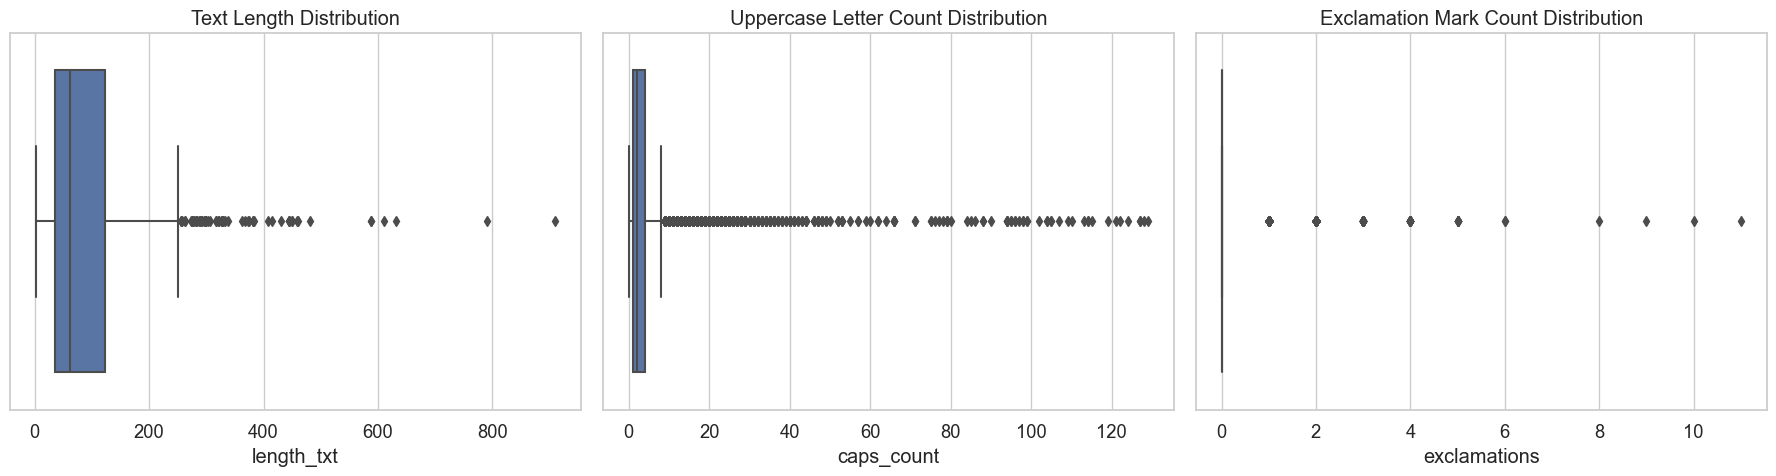

In [117]:
# Box plot for custom features
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df['length_txt'])
plt.title('Text Length Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(x=df['caps_count'])
plt.title('Uppercase Letter Count Distribution')

plt.subplot(1, 3, 3)
sns.boxplot(x=df['exclamations'])
plt.title('Exclamation Mark Count Distribution')

plt.tight_layout()
plt.show()

In [118]:
# Upon plotting the box plot, I noticed many outliers
Q1 = df[custom_features].quantile(0.25)
Q3 = df[custom_features].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR
outliers = ((df[custom_features] < (Q1 - 1.5 * IQR)) | (df[custom_features] > (Q3 + 1.5 * IQR)))

# Add a column to flag rows with any outliers
df['has_outlier'] = outliers.any(axis=1)

# Print out the outliers for review
len(df[df['has_outlier']])

1411

In [119]:
# In order to decide what to do with the outliers, we check the text data of outliers rows
# We randomly select 30 samples from 1411 outlier rows to manually inspect
sample_outliers = df[df['has_outlier']].sample(n=30, random_state=1)
print(sample_outliers['v2'])

3055                             Webpage s not available!
4603                  THANX 4 PUTTIN DA FONE DOWN ON ME!!
1692    Weightloss! No more girl friends. Make loads o...
5497    SMS SERVICES. for your inclusive text credits,...
1643                  U WILL SWITCH YOUR FONE ON DAMMIT!!
3160    Mystery solved! Just opened my email and he's ...
3271    MOON has come to color your dreams, STARS to m...
780     Your opinion about me? 1. Over 2. Jada 3. Kusr...
2685    URGENT! We are trying to contact U. Todays dra...
2944    Hey babe, sorry i didn't get sooner. Gary can ...
5467    Get your garden ready for summer with a FREE s...
1649                       ITS A LAPTOP TAKE IT WITH YOU.
3681    Hello, hello, hi lou sorry it took so long 2 r...
2594    ThatÛ÷s the thing with apes, u can fight to t...
2412    I don't know u and u don't know me. Send CHAT ...
3593    Do you want a New Nokia 3510i Colour Phone Del...
3321    Ok darlin i supose it was ok i just worry too ...
792     Y?WHER

In [120]:
# Upon chekcing, the outliers seem to be normal text messages, so we decided to keep them
# To handle outliers better, we can incoporate tree-based models, as they are more robust against outliers
# Next step is data transformation

# Remove non-English characters
df['v2'] = df['v2'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Convert to lowercase
df['v2'] = df['v2'].str.lower()

# Tokenization
df['tokens'] = df['v2'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

# Drop the temporary 'tokens' column if not needed
df = df.drop(columns=['tokens'])
df = df.drop(columns=['v2'])

print(df.head())

   label  length_txt  caps_count  exclamations  has_outlier  \
0      0         111           3             0        False   
1      0          29           2             0        False   
2      1         155          10             0         True   
3      0          49           2             0        False   
4      0          61           2             0        False   

                                   preprocessed_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  


In [121]:
# After the steps above, the data became more useful to classification models
# Now we can do training and testing split
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=179)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['preprocessed_text'])

# Combine TF-IDF features with custom features
X_train_final = hstack([X_train_tfidf, X_train[custom_features]])
X_test_final = hstack([X_test_tfidf, X_test[custom_features]])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

feature_names = np.concatenate([tfidf_feature_names, custom_features])

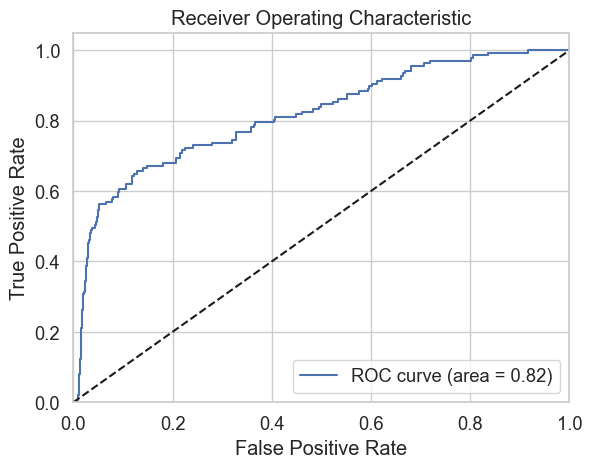

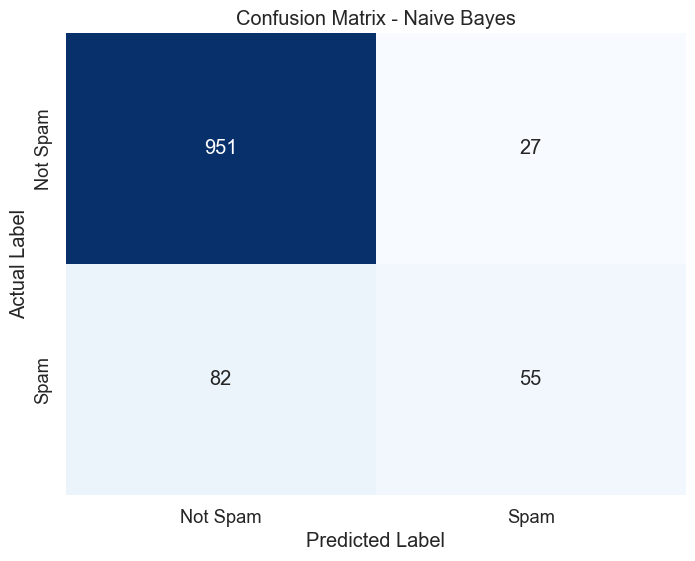

In [122]:
# Model Traning and Fitting
#----------------------------------------------------------------------------

#This variable will store model performance metrics with the function below
metrics_df = pd.DataFrame()

def evaluate_model_performance(y_test, y_pred, model_name, y_score=None):
    """
    Evaluate model performance and store the metrics in a DataFrame.

    Parameters:
    y_test (array): True labels.
    y_pred (array): Predicted labels.
    model_name (str): Name of the model.
    y_score (array, optional): Probability estimates of the positive class.

    Returns:
    DataFrame: A DataFrame containing the performance metrics for the model.
    """
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred)
    }

        
    if y_score is not None:
        roc_auc = roc_auc_score(y_test, y_score)
        metrics['ROC AUC'] = roc_auc

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return pd.DataFrame([metrics])

# For each model, we will plot the ROC curve along with confusion matrix to observe performance
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_final, y_train)

y_pred_nb = nb.predict(X_test_final)
y_score_nb = nb.predict_proba(X_test_final)[:, 1]

nb_results = evaluate_model_performance(y_test, y_pred_nb, "Naive Bayes", y_score=y_score_nb)
metrics_df = pd.concat([metrics_df, nb_results], ignore_index=True)

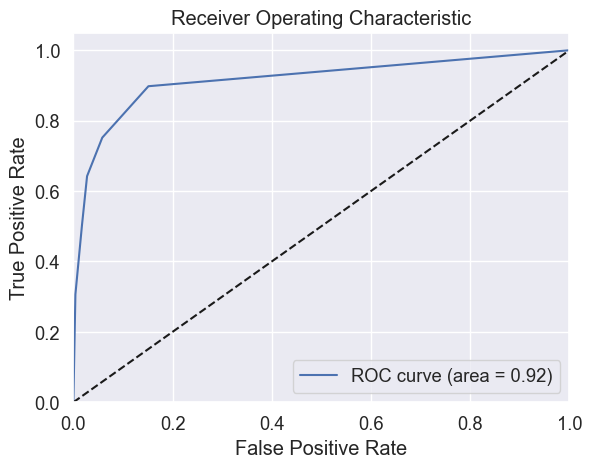

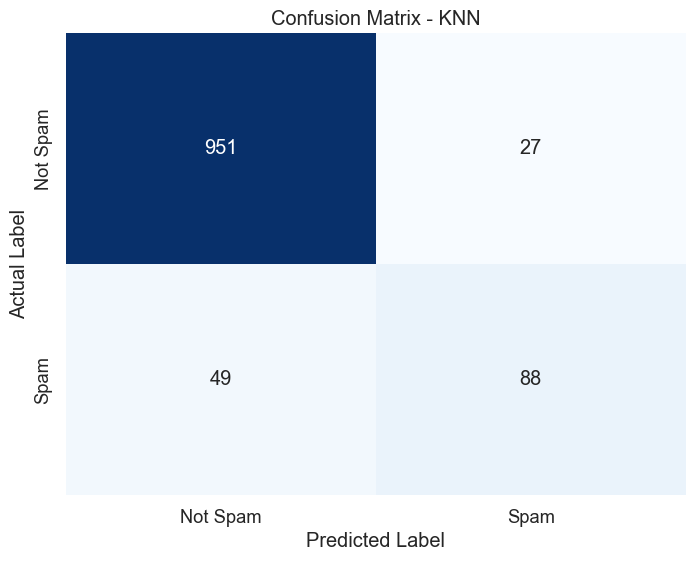

In [123]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_final, y_train)

y_pred_knn = knn.predict(X_test_final)
y_score_knn = knn.predict_proba(X_test_final)[:, 1]

knn_results = evaluate_model_performance(y_test, y_pred_knn, "KNN", y_score=y_score_knn)
metrics_df = pd.concat([metrics_df, knn_results], ignore_index=True)

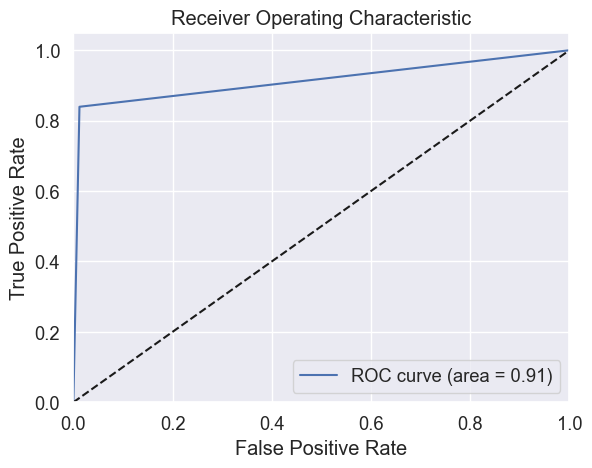

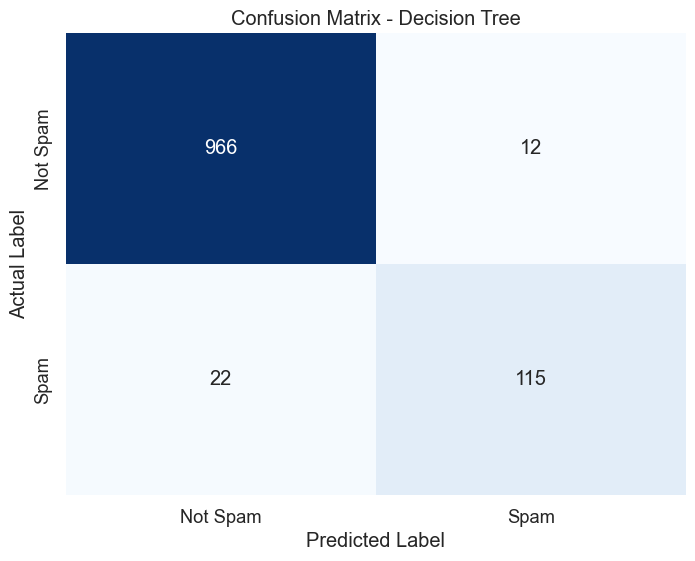

In [124]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=179)
dt.fit(X_train_final, y_train)

y_pred_dt = dt.predict(X_test_final)
y_score_dt = dt.predict_proba(X_test_final)[:, 1]

dt_results = evaluate_model_performance(y_test, y_pred_dt, "Decision Tree", y_score=y_score_dt)
metrics_df = pd.concat([metrics_df, dt_results], ignore_index=True)

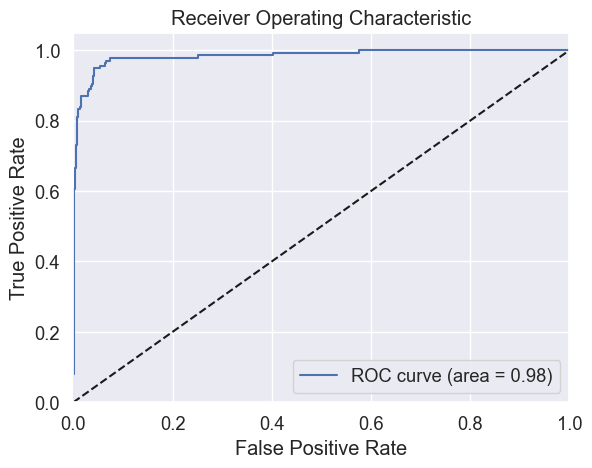

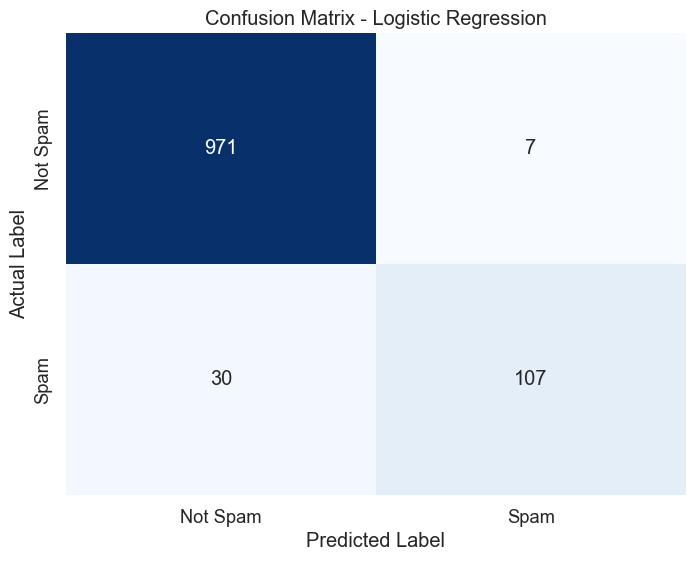

In [125]:
# Logistic Regression
lr = LogisticRegression(random_state=179, max_iter=1000)
lr.fit(X_train_final, y_train)

y_pred_lr = lr.predict(X_test_final)
y_score_lr = lr.predict_proba(X_test_final)[:, 1]

lr_results = evaluate_model_performance(y_test, y_pred_lr, "Logistic Regression", y_score=y_score_lr)
metrics_df = pd.concat([metrics_df, lr_results], ignore_index=True)

C:\Users\zhang\anaconda3\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
C:\Users\zhang\anaconda3\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


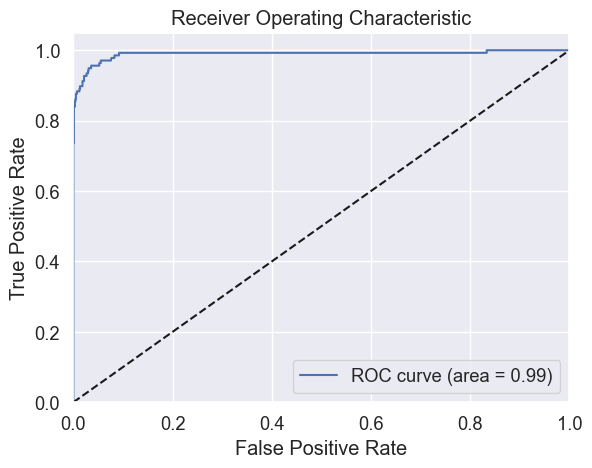

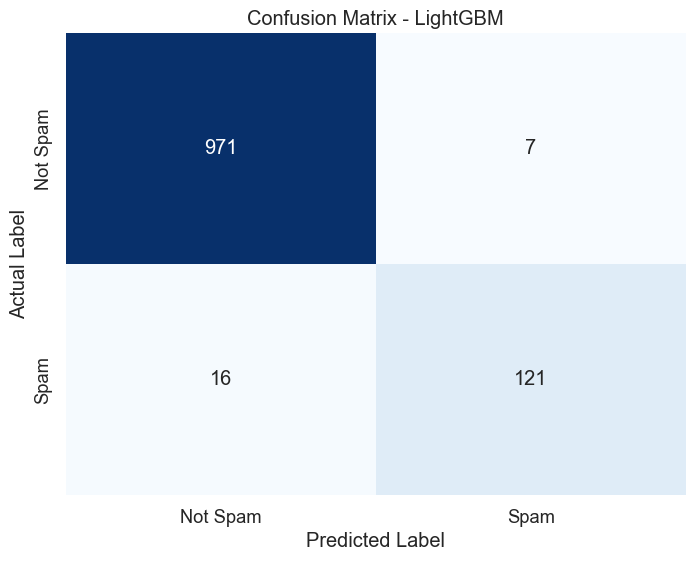

In [126]:
# LightGBM Classifier
lgbm_model = lgb.LGBMClassifier(random_state=179,verbose=-1)

lgbm_model.fit(X_train_final, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_final)
y_score_lgbm = lgbm_model.predict_proba(X_test_final)[:, 1]

lgbm_results = evaluate_model_performance(y_test, y_pred_lgbm, "LightGBM", y_score=y_score_lgbm)
metrics_df = pd.concat([metrics_df, lgbm_results], ignore_index=True)

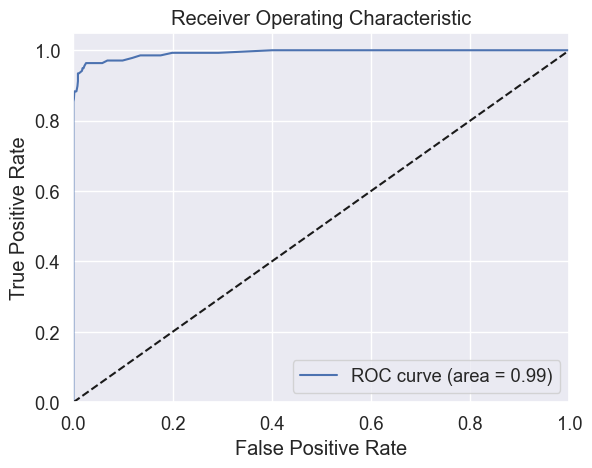

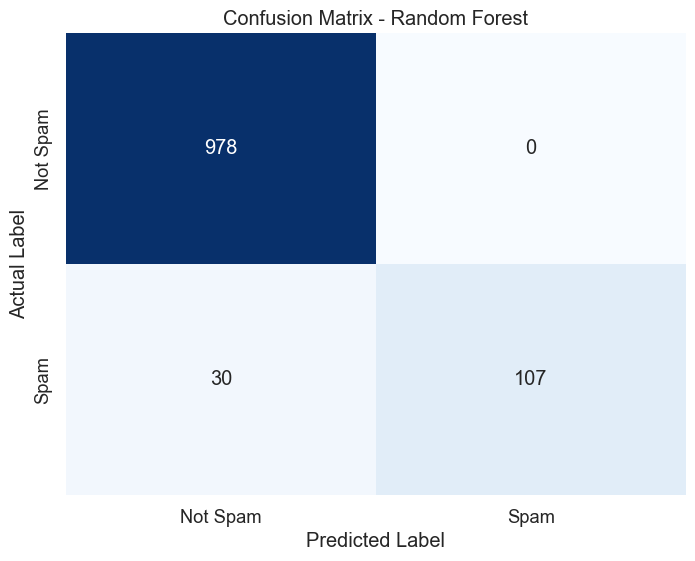

In [127]:
# Random Forest
rf = RandomForestClassifier(random_state=179)
rf.fit(X_train_final, y_train)

y_pred_rf = rf.predict(X_test_final)
y_score_rf = rf.predict_proba(X_test_final)[:,1]

rf_results = evaluate_model_performance(y_test, y_pred_rf, "Random Forest", y_score=y_score_rf)
metrics_df = pd.concat([metrics_df, rf_results], ignore_index=True)


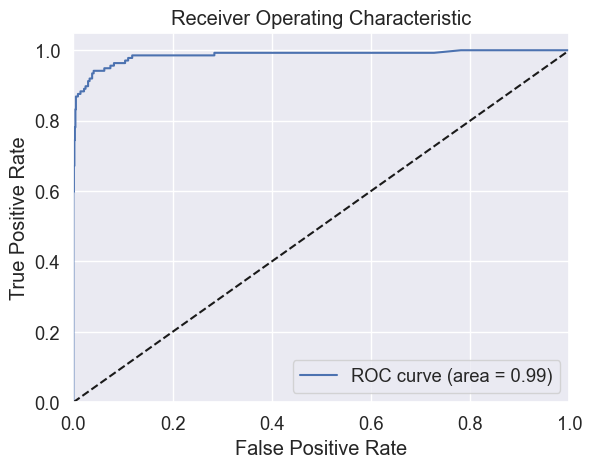

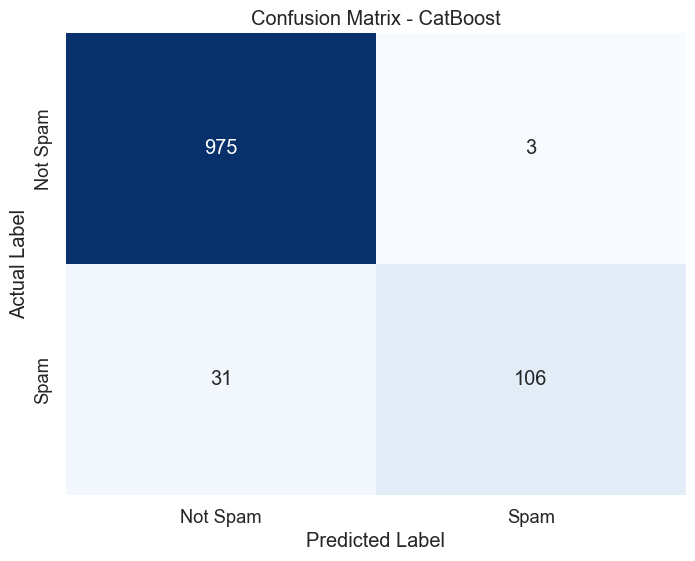

In [128]:
# Catboost
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    random_seed=179,
    verbose=0  # Adjust this for more or less frequent logging of training progress
)

catboost_model.fit(X_train_final, y_train)

y_pred_catboost = catboost_model.predict(X_test_final)
y_score_catboost = catboost_model.predict_proba(X_test_final)[:, 1]

catboost_results = evaluate_model_performance(y_test, y_pred_catboost, "CatBoost", y_score=y_score_catboost)
metrics_df = pd.concat([metrics_df, catboost_results], ignore_index=True)

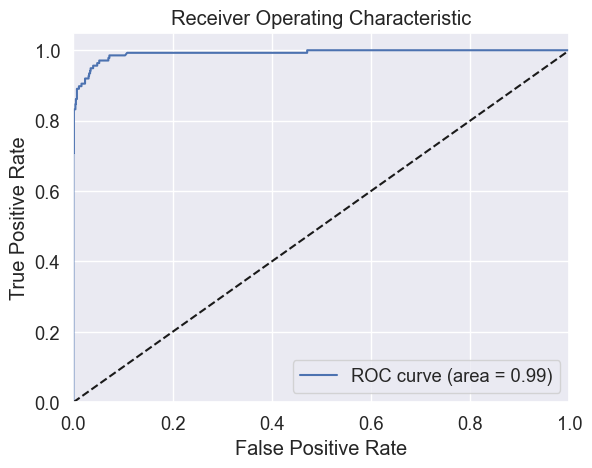

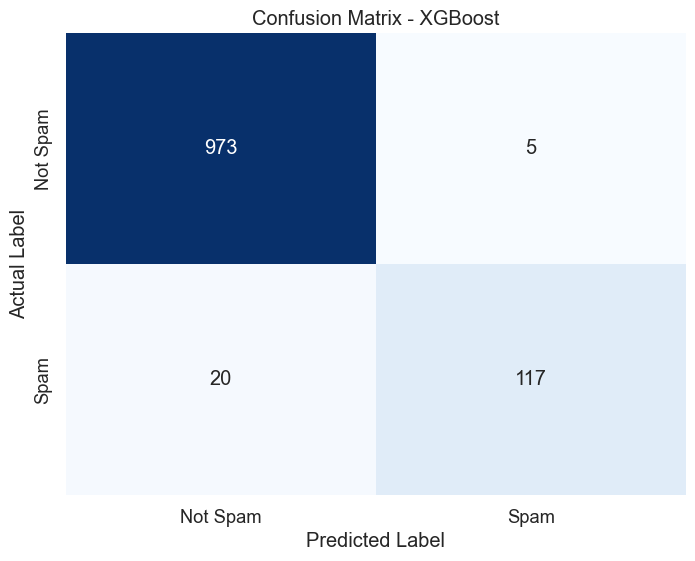

In [129]:
# XGBoost
xgb_clf = xgb.XGBClassifier(random_state=179, use_label_encoder=False, eval_metric='logloss')

xgb_clf.fit(X_train_final, y_train)

y_pred_xgb = xgb_clf.predict(X_test_final)
y_score_xgb = xgb_clf.predict_proba(X_test_final)[:, 1]

xgb_results = evaluate_model_performance(y_test, y_pred_xgb, "XGBoost", y_score=y_score_xgb)
metrics_df = pd.concat([metrics_df, xgb_results], ignore_index=True)

In [130]:
sorted_metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)
print(sorted_metrics_df)

                 Model  Accuracy  F1 Score    Recall  Precision   ROC AUC
4             LightGBM  0.979372  0.913208  0.883212   0.945312  0.989331
7              XGBoost  0.977578  0.903475  0.854015   0.959016  0.991745
5        Random Forest  0.973094  0.877049  0.781022   1.000000  0.992880
2        Decision Tree  0.969507  0.871212  0.839416   0.905512  0.913573
6             CatBoost  0.969507  0.861789  0.773723   0.972477  0.985629
3  Logistic Regression  0.966816  0.852590  0.781022   0.938596  0.983625
1                  KNN  0.931839  0.698413  0.642336   0.765217  0.915308
0          Naive Bayes  0.902242  0.502283  0.401460   0.670732  0.815727


In [131]:
# Overall, the models are performing very well
# Best models in this case seem to be LightGBM, XGBoost, and Random Forest, so we will focuse on them

# Function that computes cross validation score of a model based on F1 scores
def cv_score(model, num_of_fold, model_name):
    scores = cross_val_score(model, X_train_final, y_train, cv=num_of_fold, scoring='f1')
    print('For ', model_name)
    print("F1 per fold: ", scores)
    print("Average F1: ", scores.mean())
    print("Standard deviation: ", scores.std())
    print("\n")

cv_score(xgb_clf, 5, 'XGBoost')
cv_score(lgbm_model, 5, 'LightGBM')
cv_score(rf, 5, 'Random Forest')

For  XGBoost
F1 per fold:  [0.90128755 0.92765957 0.86580087 0.90748899 0.94468085]
Average F1:  0.9093835663529981
Standard deviation:  0.026640185515338165


For  LightGBM
F1 per fold:  [0.91983122 0.90833333 0.88983051 0.90178571 0.96296296]
Average F1:  0.9165487485370558
Standard deviation:  0.025156941478698975


For  Random Forest
F1 per fold:  [0.92035398 0.93043478 0.91071429 0.88584475 0.93043478]
Average F1:  0.9155565164182018
Standard deviation:  0.01656488827780437




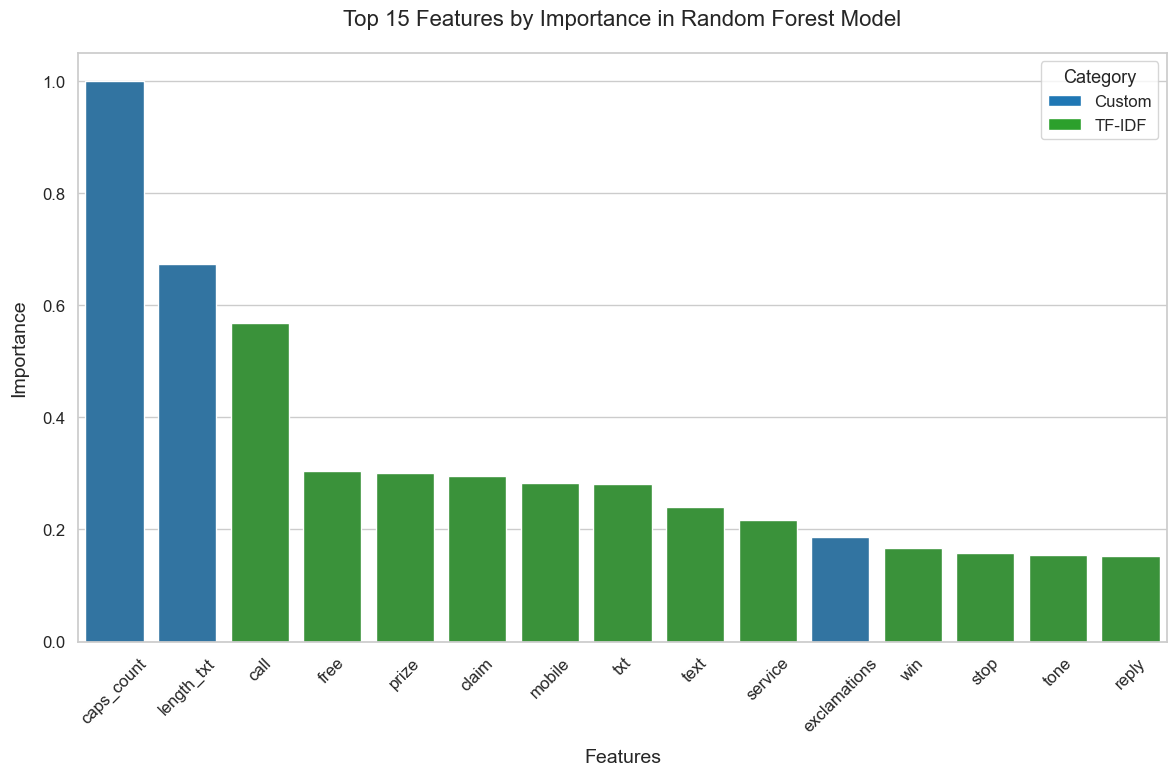

In [132]:
# Model performance seem to be robust in cross validation
# We are interested in the features that the models deem as important
top_features_list = []

def plot_top_15_features(model, custom_features, model_name, importance_col='Importance'):
    """
    Plots the top 15 features by importance for a given model.

    Parameters:
    feature_importance_df (DataFrame): DataFrame containing features and their importance.
    custom_features (list): List of features considered as 'Custom'.
    model_name (str): Name of the model for the plot title.
    importance_col (str): Name of the column in feature_importance_df that represents the feature importance.
    """
    scaler = MinMaxScaler()

    # Reshape the feature importances to a 2D array for the scaler
    feature_importances = scaler.fit_transform(model.feature_importances_.reshape(-1, 1)).flatten()

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort by importance and select top 10
    top_15_features = feature_importance_df.nlargest(15, 'Importance')
    top_features_list.append(top_15_features)

    # Categorize features as 'Custom' or 'TF-IDF'
    top_15_features['Category'] = top_15_features['Feature'].apply(
        lambda x: 'Custom' if x in custom_features else 'TF-IDF'
    )

    # Map categories to colors
    colors = top_15_features['Category'].map({
        'Custom': '#1f77b4',  
        'TF-IDF': '#2ca02c', 
    })

    # Plot top 10 feature importances with category-based coloring
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x=top_15_features['Feature'], y=top_15_features[importance_col], palette=colors)
    plt.xlabel('Features', fontsize=14, labelpad=10)
    plt.ylabel('Importance', fontsize=14, labelpad=10)
    plt.title(f'Top 15 Features by {importance_col} in {model_name} Model', fontsize=16, pad=20)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    legend_handles = [
    Patch(facecolor='#1f77b4', label='Custom'),
    Patch(facecolor='#2ca02c', label='TF-IDF')]

    plt.legend(handles=legend_handles, title='Category', title_fontsize='13', fontsize='12', loc='upper right')

    plt.show()

# We plot the top 15 features for the 3 best performing models
# Features in blue were added during preprocessing, features in green are from original data
plot_top_15_features(rf, custom_features, 'Random Forest', importance_col='Importance')


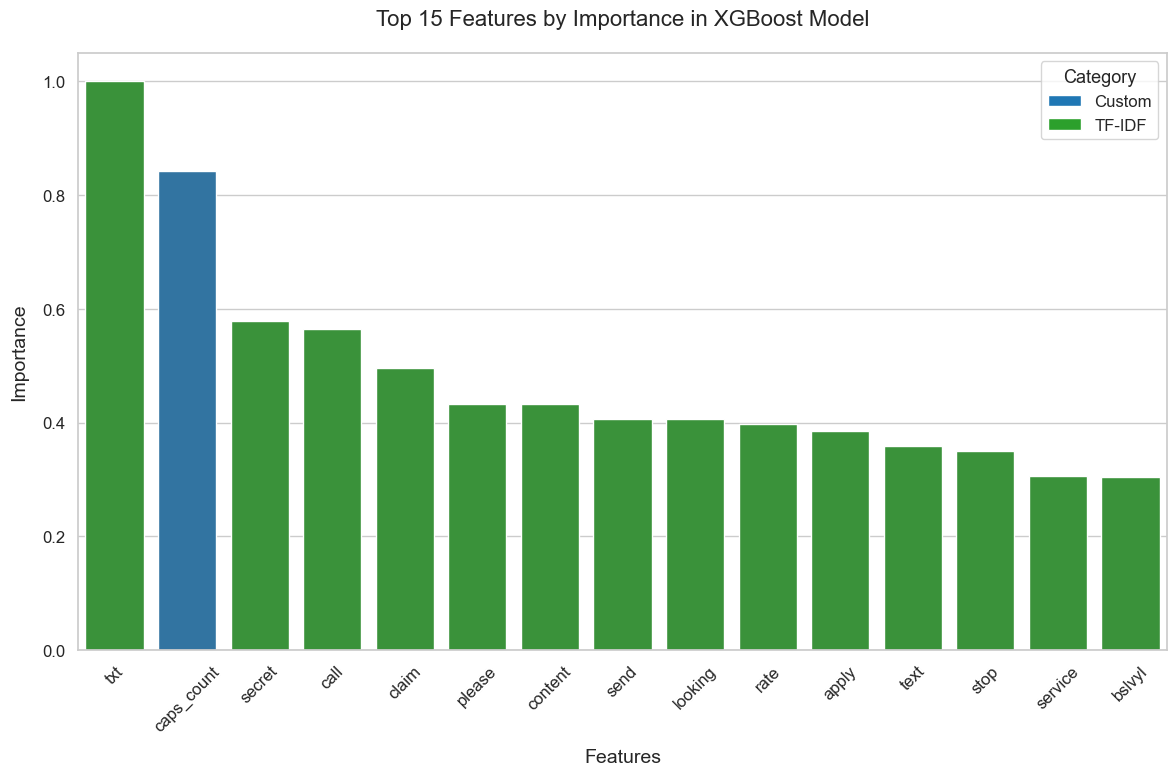

In [133]:
plot_top_15_features(xgb_clf, custom_features, 'XGBoost', importance_col='Importance')

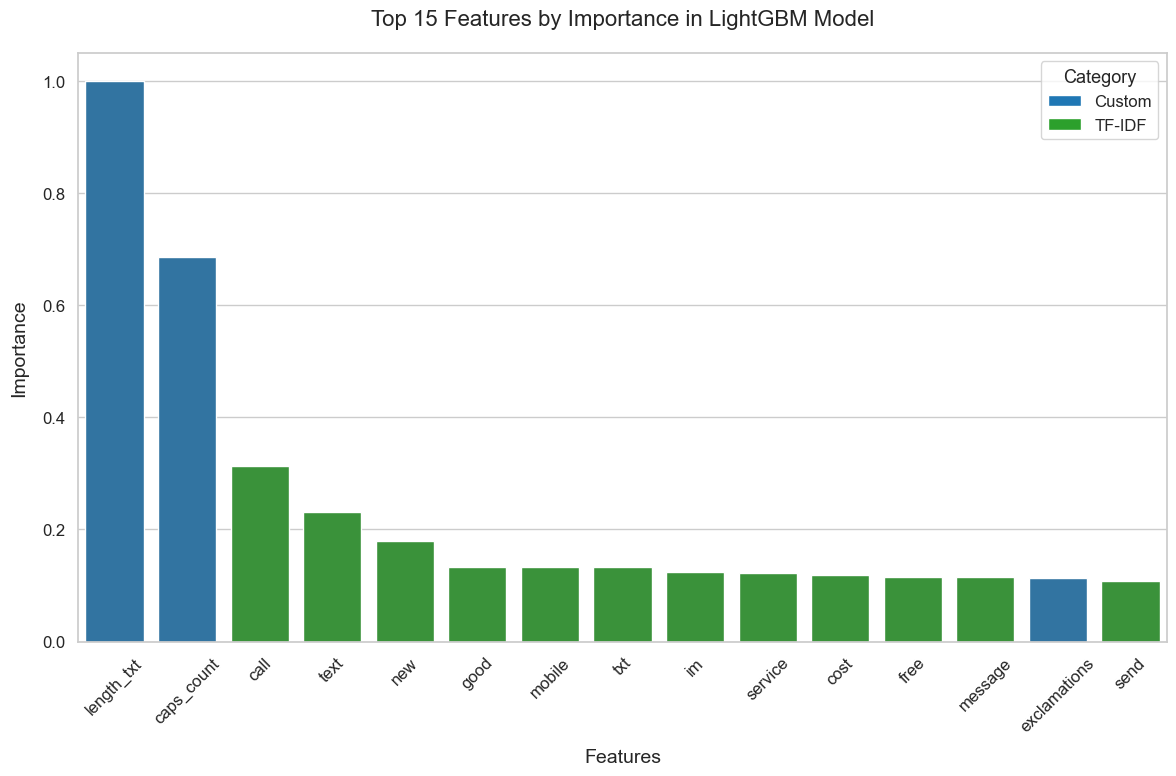

In [134]:
plot_top_15_features(lgbm_model, custom_features, 'LightGBM', importance_col='Importance')

In [135]:
df1, df2, df3 = top_features_list

# Perform inner merge on 'Feature' column to find common features
common_features = df1.merge(df2, on='Feature').merge(df3, on='Feature')

# Extract the feature names that are common
common_feature_names = common_features['Feature'].unique()

print("Features common in all three models:", common_feature_names)

Features common in all three models: ['caps_count' 'call' 'txt' 'text' 'service']


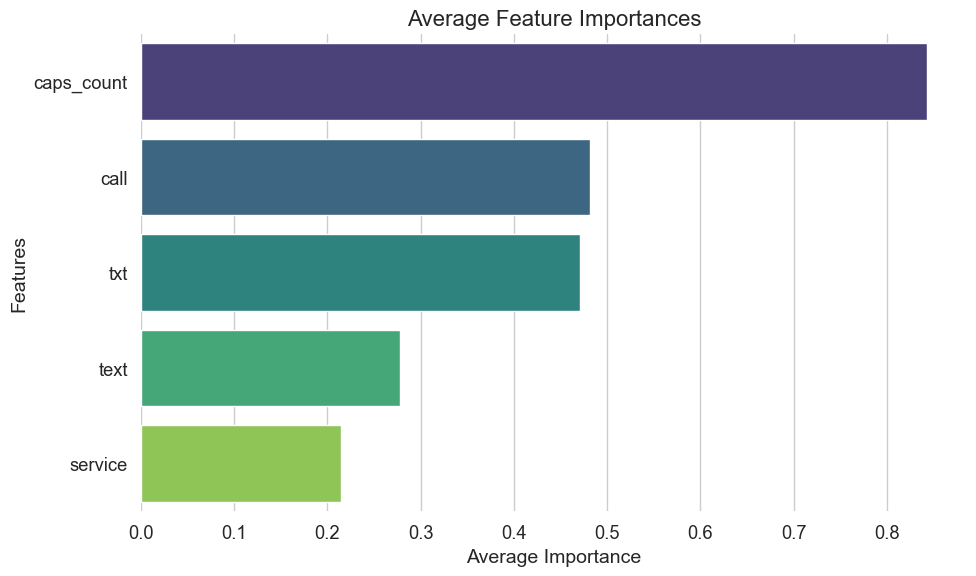

In [136]:
importance_cols = [col for col in common_features.columns if 'Importance' in col]
common_features['Combined_Importance'] = common_features[importance_cols].mean(axis=1)

# Sort by combined importance
common_features_sorted = common_features[['Feature', 'Combined_Importance']].sort_values(by='Combined_Importance', ascending=False)

"""
We can see from the plot that caps_count has the highest aveage importance. It seems to make sense, since many of
the spam messages I received were in all caps. For the other four features like call, txt, text, service, in this context
most likely suggest that the appearance of these words are highly assiociated with a spam message.
"""

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Combined_Importance', y='Feature', data=common_features_sorted, palette='viridis')
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Average Feature Importances', fontsize=16)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

